In [1]:
import numpy as np
from config import Config
from reconstructor_mjw import Reconstructor

import matplotlib.pyplot as plt
import h5py
from cuda import cuda, nvrtc
import time

In [2]:

c = Config('ConfigFiles/RealG15_mjw.yml')
# c.grainID = 25
r = Reconstructor(c)

90


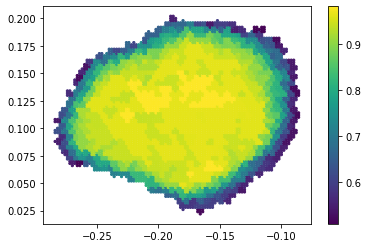

6266
3.934260368347168
0
4.418284177780151
1000
4.319246768951416
2000
4.342855453491211
3000
4.280336618423462
4000
4.21600604057312
5000
4.244330406188965
6000


In [3]:
with h5py.File(c.micFile,'r') as f:
    GrainIDMap = f["GrainID"][:].astype(int)
    grid_x = f["Xcoordinate"][:]
    grid_y = f["Ycoordinate"][:]
    grid_c = f["Confidence"][:]

mask = np.where(GrainIDMap==c.grainID)
x = grid_x[mask]
y = grid_y[mask]
con = grid_c[mask]

threshold=0.5

fig, ax = plt.subplots()
cax=ax.scatter(x[con>threshold],y[con>threshold],c=con[con>threshold],s=5)
cbar = fig.colorbar(cax)

plt.show()

tmpx=x[con>threshold]
tmpy=y[con>threshold]

print(len(x[con>threshold]))
Phase1_Conf, Phase1_S = r.ReconGridsPhase1(tmpx,tmpy,NumD=500)


In [4]:

r.SimPhase1Result(tmpx,tmpy,Phase1_S)

(6266, 90)


In [5]:
tmpS=Phase1_S.copy()
Phase2_S, history = r.ReconGridsPhase2(tmpx,tmpy,tmpS,iterN=10,NumD=500)


1/10, loss=0
2/10, loss=-215878.6519124508
3/10, loss=-289269.1502985954
4/10, loss=-314374.9359331131
5/10, loss=-330363.0064673424
6/10, loss=-335943.6450641155
7/10, loss=-340998.6186783314
8/10, loss=-344290.38741213083
9/10, loss=-343653.63412195444
10/10, loss=-347147.9356134534


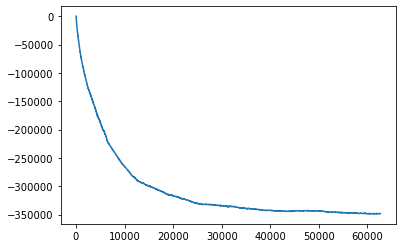

In [6]:
plt.plot(history)
plt.show()


In [7]:
# Phase2_S = np.load('Phase2_S.npy')
realO,realS = r.Transform2RealS(Phase2_S)

with h5py.File(c.recFile, 'w') as f:
    f.create_dataset("x", data=tmpx)
    f.create_dataset("y", data=tmpy)

    f.create_dataset("Phase1_Conf", data=Phase1_Conf)
    f.create_dataset("Phase1_S", data=Phase1_S)

    f.create_dataset("Phase2_S", data=Phase2_S)

    f.create_dataset('Phase2_history', data=history)

    f.create_dataset("realS", data=realS)
    f.create_dataset("realO", data=realO)


In [8]:
np.save('G_15_realS',realS)
np.save('G_15_tmpx',tmpx)
np.save('G_15_tmpy',tmpy)

In [ ]:


tx = np.concatenate([np.load('G_15_realS.npy'

(6266, 3, 3)


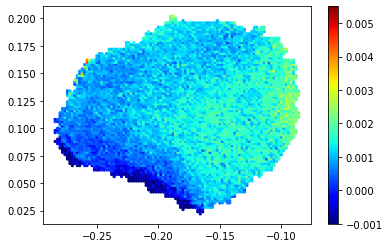

In [9]:
print(realS.shape)
comp=[2,2]
fig, ax = plt.subplots()
cax=ax.scatter(tmpx,tmpy,c=realS[:,comp[0],comp[1]]-1,
               s=5,cmap='jet',
               # vmin=-0.0097,vmax=-0.0059
              vmin=-0.001,vmax=0.0055
              )
cbar = fig.colorbar(cax)
# fig.savefig('Szz_1.png',format='png',dpi=300)
plt.show()

In [10]:
# r.recon.pair_pix_to_vox(tmpx,tmpy,Phase2_S)

In [11]:
# np.save('Phase2_S',Phase2_S)

simulatedMaps,pixels=r.recon.simMap(tmpx,tmpy,Phase2_S,blur=False,dtype=np.uint32)

(6266, 90)


In [12]:
xx,yy,oo,mask = pixels



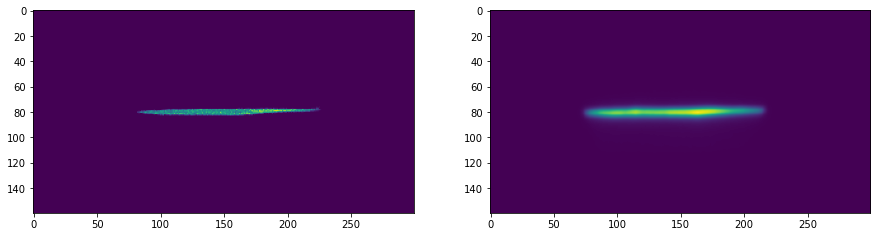

In [13]:
ii = 2
offset = np.where(r.peakFile['Imgs']['Im%s'%ii][:]==np.max(r.peakFile['Imgs']['Im%s'%ii][:]))[2][0]
fig,axs=plt.subplots(1,2,figsize=(15,8))
axs[0].imshow(simulatedMaps[:,:,45*ii+offset])
axs[1].imshow(r.peakFile['Imgs']['Im{0:d}'.format(ii)][:,:,offset])
plt.show()

In [14]:

grain_dict = {}

for i in range(xx.shape[0]):   
    g = {}
    for j in range(xx.shape[1]):
        g[f'Peak_{j}'] = np.stack([xx[i,j],yy[i,j],oo[i,j]])
        
    grain_dict[f'Voxel_{np.round(tmpx[i],3)}_{np.round(tmpy[i],3)}'] = g

# print(grain_dict['Voxel_-0.166_0.022'])
        
    
    
peak_dict = {}

for i in range(xx.shape[1]):  
    p = {}
    mask_p = mask[:,i]
    det_x = xx[mask_p,i]
    det_y = yy[mask_p,i]
    det_o = oo[mask_p,i]
    vox_x = tmpx[mask_p]
    vox_y = tmpy[mask_p]
    for x,y,o,sx,sy in zip(det_x,det_y,det_o,vox_x,vox_y):
        sx = np.round(sx,3)
        sy = np.round(sy,3)
        if f'Pixel_{x}_{y}_{o}' in p.keys():
            p[f'Pixel_{x}_{y}_{o}'].append( [sx,sy])
        else:
            p[f'Pixel_{x}_{y}_{o}'] =  [[sx,sy]]
        
        
    peak_dict[f'Peak_{i}'] = p
    
print(peak_dict['Peak_75'])




{'Pixel_105_88_24': [[-0.166, 0.022]], 'Pixel_106_87_24': [[-0.168, 0.024], [-0.166, 0.026], [-0.158, 0.032], [-0.158, 0.034], [-0.156, 0.036], [-0.154, 0.04], [-0.152, 0.042]], 'Pixel_105_87_24': [[-0.166, 0.024], [-0.164, 0.026], [-0.15, 0.042]], 'Pixel_104_86_24': [[-0.164, 0.024], [-0.156, 0.032], [-0.154, 0.034]], 'Pixel_115_89_24': [[-0.18, 0.026]], 'Pixel_108_88_24': [[-0.168, 0.026], [-0.166, 0.028], [-0.16, 0.034]], 'Pixel_117_88_24': [[-0.182, 0.028], [-0.182, 0.03], [-0.18, 0.032], [-0.178, 0.036], [-0.174, 0.038], [-0.174, 0.04]], 'Pixel_115_88_24': [[-0.18, 0.028], [-0.172, 0.036], [-0.17, 0.038]], 'Pixel_114_88_24': [[-0.178, 0.028], [-0.174, 0.032], [-0.172, 0.032], [-0.17, 0.036]], 'Pixel_112_87_24': [[-0.176, 0.028], [-0.164, 0.04], [-0.164, 0.042]], 'Pixel_111_87_24': [[-0.174, 0.028], [-0.166, 0.036], [-0.162, 0.04], [-0.162, 0.042]], 'Pixel_111_88_24': [[-0.172, 0.028], [-0.17, 0.03], [-0.168, 0.03], [-0.166, 0.034], [-0.164, 0.038]], 'Pixel_110_88_24': [[-0.17, 0.0

In [15]:



def save_as_hdf(peaks,gs,outfile):
    
    data_file = h5py.File(outfile,'w')
    for pk,g in zip(peaks,gs):
        data_file.create_group('%s'%g)
        data_file['%s'%g].create_dataset('reflection',data=g,dtype='i')
        data_file['%s'%g].create_dataset('data',data=pk,dtype='f')
    data_file.close()
    return

In [16]:
4050/90

45.0